# Focal Diversity-based Ensemble Selection

This demo provides the focal diversity-based ensemble selection.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


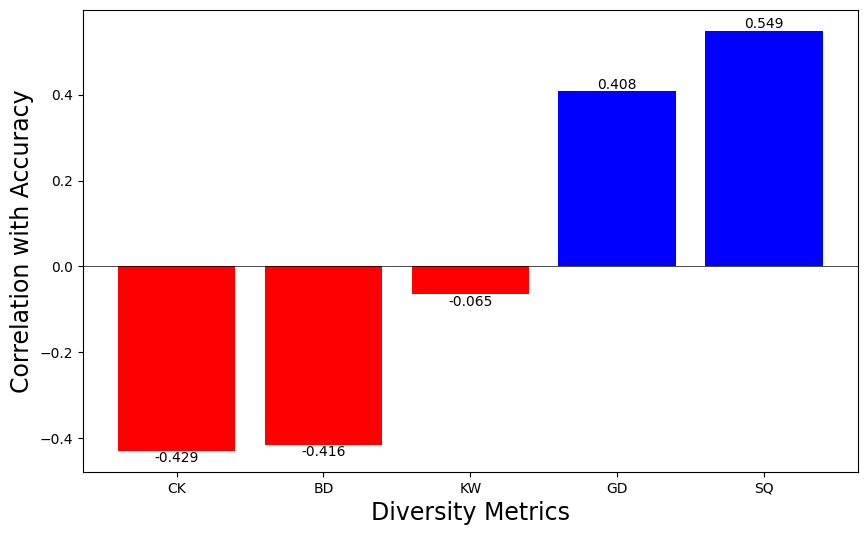

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation values (in 1 ratio) between each metric and accuracy
metrics = ['CK', 'BD', 'KW', 'GD', 'SQ']
correlations = [-0.429, -0.416, -0.065, 0.408, 0.549]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red' if corr < 0 else 'blue' for corr in correlations]  # Red for negative, blue for positive
bars = plt.bar(metrics, correlations, color=colors)

# Adding value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom' if yval > 0 else 'top')

# Labels and title
plt.xlabel('Diversity Metrics', fontsize=17)
plt.ylabel('Correlation with Accuracy', fontsize=17)
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line at 0

# Show plot
plt.show()


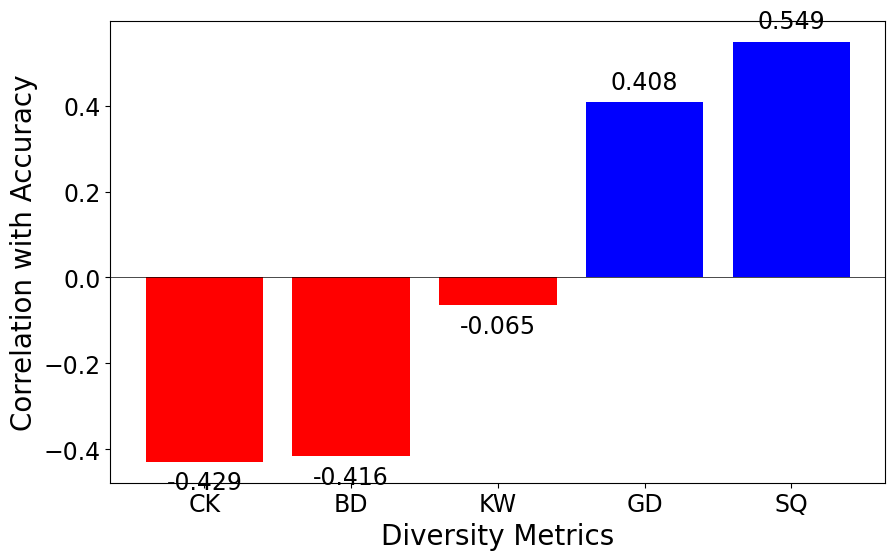

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Correlation values (in 1 ratio) between each metric and accuracy
metrics = ['CK', 'BD', 'KW', 'GD', 'SQ']
correlations = [-0.429, -0.416, -0.065, 0.408, 0.549]

# Plotting
plt.figure(figsize=(10, 6))
colors = ['red' if corr < 0 else 'blue' for corr in correlations]  # Red for negative, blue for positive
bars = plt.bar(metrics, correlations, color=colors)

# Adding value labels with better placement and font size
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + (0.02 if yval > 0 else -0.02),  # Offset to prevent overlap
        f'{yval:.3f}',
        ha='center',
        va='bottom' if yval > 0 else 'top',
        fontsize=17  # Adjust font size if necessary
    )

# Labels and title with font size 20
plt.xlabel('Diversity Metrics', fontsize=20)
plt.ylabel('Correlation with Accuracy', fontsize=20)


# Setting font size for x and y ticks
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

# Adding a horizontal line at 0 for reference
plt.axhline(0, color='black', linewidth=0.5)

# Show plot
plt.show()


In [2]:
import os
import time
import torch
import numpy as np
from itertools import combinations
import timeit
import sys
import pickle
sys.path.append('/content/drive/MyDrive/Jin')


# Import the necessary utility functions
from pytorchUtility import (
    calAccuracy,
    calAveragePredictionVectorAccuracy,
    calNegativeSamplesSet,
    calDisagreementSamplesOneTargetNegative,
    filterModelsFixed,
)

from diversityMetrics import *
from teamSelection import *
from sklearnUtility import *
from groupMetrics import *
%load_ext autoreload
%autoreload 2

# simply use the extracted prediction results to calculate the diversity scores and perform ensemble selection

diversityMetricsList = ['KW', 'GD', 'CK', 'BD', 'CK2', 'BD2']

predictionDir = '/content/drive/MyDrive/testPredictions'
models = ['densenet169', 'densenet121', 'EfficientNetB3', 'EfficientNetB4',
          'densenet201', 'ResNet50', 'resnet101', 'resnet152', 'vit', 'finetunedvit']


In [3]:
import os
import numpy as np
import torch

# Load the label vectors from 'val_labels.npy'
label_path = os.path.join(predictionDir, 'test_labels.npy')
label_vectors = np.load(label_path, allow_pickle=True)

# Initialize lists for predictions and accuracies
prediction_vectors_list = []
tmp_acc_list = []

# Loop through each model and load its predictions
for m in models:
    # Construct the prediction path for each model's .npy file
    prediction_path = os.path.join(predictionDir, m + '.npy')

    # Load the predictions from the .npy file
    prediction_vectors = np.load(prediction_path, allow_pickle=True)

    # Convert prediction vectors to PyTorch tensors
    prediction_vectors = torch.tensor(prediction_vectors)

    # Print some information for debugging
    print(m, prediction_vectors[0].sum(), prediction_vectors.sum())

    # Store the prediction vectors in the list
    prediction_vectors_list.append(prediction_vectors)

    # Calculate the accuracy using the already loaded label vectors
    tmp_acc_list.append(calAccuracy(prediction_vectors, torch.tensor(label_vectors))[0].cpu())

    # Print the accuracy for the current model
    print(tmp_acc_list[-1])

# Check if there are any accuracies in the list before calculating min, avg, max
if tmp_acc_list:
    # Calculate and print the minimum, average, and maximum accuracies
    min_acc = round(np.min(tmp_acc_list),2)
    avg_acc = round(np.mean(tmp_acc_list),2)
    max_acc = round(np.max(tmp_acc_list),2)

    print(f"Minimum accuracy: {min_acc}")
    print(f"Average accuracy: {avg_acc}")
    print(f"Maximum accuracy: {max_acc}")
else:
    print("No accuracy results were calculated.")


densenet169 tensor(1.) tensor(8081.)
tensor(96.4113)
densenet121 tensor(1.) tensor(8081.)
tensor(99.1461)
EfficientNetB3 tensor(1.) tensor(8081.)
tensor(98.5150)
EfficientNetB4 tensor(1.0000) tensor(8081.)
tensor(98.7254)
densenet201 tensor(1.0000) tensor(8081.)
tensor(97.7973)
ResNet50 tensor(1., dtype=torch.float16) tensor(8080., dtype=torch.float16)
tensor(97.4879)
resnet101 tensor(1., dtype=torch.float16) tensor(8080., dtype=torch.float16)
tensor(96.6960)
resnet152 tensor(1., dtype=torch.float16) tensor(8080., dtype=torch.float16)
tensor(96.9311)
vit tensor(1.0000) tensor(8081.)
tensor(96.8816)
finetunedvit tensor(1.0000) tensor(8081.)
tensor(98.4779)
Minimum accuracy: 96.41000366210938
Average accuracy: 97.70999908447266
Maximum accuracy: 99.1500015258789


In [4]:
import os
import numpy as np
import torch

# Preprocessing
labelVectorsList = list()
predictionVectorsList = list()
tmpAccList = list()

# Load the label vectors from 'val_labels.npy' and convert to tensor
label_path = os.path.join(predictionDir, 'test_labels.npy')
labelVectors = torch.tensor(np.load(label_path, allow_pickle=True)).cpu()

# Loop through each model and load its predictions from .npy files
for model_name in models:
    # Construct the prediction path for each model's .npy file
    prediction_path = os.path.join(predictionDir, f"{model_name}.npy")

    # Load the predictions using numpy and convert to PyTorch tensor
    predictionVectors = torch.tensor(np.load(prediction_path, allow_pickle=True))

    # Apply softmax to the prediction vectors (same as legacy code)
    predictionVectors = torch.nn.functional.softmax(predictionVectors, dim=-1).cpu()

    # Append to the lists (same as legacy code)
    predictionVectorsList.append(predictionVectors)
    labelVectorsList.append(labelVectors)

    # Calculate the accuracy using tensors and append to the list
    tmpAccList.append(calAccuracy(predictionVectors, labelVectors)[0].cpu())

    # Print the accuracy for the current model (as tensor)
    print(tmpAccList[-1])

# Calculate min, average, and max accuracy (kept as tensors)
minAcc = np.min(tmpAccList)
avgAcc = np.mean(tmpAccList)
maxAcc = np.max(tmpAccList)

# Print the final min, avg, and max accuracies



tensor(96.4113)
tensor(99.1461)
tensor(98.5150)
tensor(98.7254)
tensor(97.7973)
tensor(97.4879)
tensor(96.6960)
tensor(96.9435)
tensor(96.8816)
tensor(98.4779)


In [5]:
import inspect
print(inspect.getsource(calDiversityMetric))

def calDiversityMetric(prediction, target=None, metric='CK', focal_model_id=None): 
    if metric not in _allDiversityMetrics:
        raise Exception("Diversity Metric Not Found!")
    if metric == 'CK0':    
        return 1.0 - group_kappa_score0(prediction, focal_model_id)          # focal and others
    if metric == 'CK':   # 1 - all models' argeement socre
        return 1.0 - group_kappa_score(prediction)
    if metric == 'CK2':  # non-focal models' agreement socre, we wish non-focal model have high agreement to boost performance
        return group_kappa_score2(prediction, focal_model_id)
        
    if metric == 'QS' and len(target) > 0:
        return 1.0 - group_Q_statistic(prediction, target)
        
    if metric == 'BD' and len(target) > 0:   # 
        return group_binary_disagreement(prediction, target)   
    if metric == 'BD2' and len(target) > 0:  # only the diversity between focal model and others, the divrsity among non-focal models is not considered
        ret

In [6]:
import timeit
from itertools import combinations
import torch

# Preprocessing: Initialize dictionaries
teamAccuracyDict = dict()  # Team -> accuracy map
modelTeamDict = dict() # Model -> team
teamNameDict = dict()  # Team name -> selected models

# Start timing the operation
startTime = timeit.default_timer()

# Loop through different team sizes (starting from 3 models to len(models))
for n in range(3, len(models) + 1):
    # Generate combinations of models
    comb = combinations(list(range(len(models))), n)

    for selectedModels in list(comb):
        # Calculate the average accuracy for the selected models
        tmpAccuracy = calAveragePredictionVectorAccuracy(
            predictionVectorsList,  # Predictions from all models
            labelVectorsList[0],    # Labels
            modelsList=selectedModels  # The selected subset of models
        )[0].cpu().item()

        # Create a team name based on the selected models
        teamName = "".join(map(str, selectedModels))
        teamNameDict[teamName] = selectedModels

        # Store the accuracy for the team
        teamAccuracyDict[teamName] = tmpAccuracy

        # Populate the model-to-team dictionary
        for m in teamName:
            if m in modelTeamDict:
                modelTeamDict[m].add(teamName)
            else:
                modelTeamDict[m] = set([teamName])

# End timing and print the time taken
endTime = timeit.default_timer()
print("Time: ", endTime - startTime)


Time:  2.827755943999989


In [7]:
import timeit
import numpy as np
import torch

# Set random seed and cross-validation parameters
np.random.seed(0)
nRandomSamples = 100
crossValidation = True
crossValidationTimes = 3

# Define the list of diversity metrics to calculate
diversityMetricsList = ['KW', 'GD', 'CK', 'BD', 'CK2', 'BD2']

# Initialize dictionaries to store the results
teamDiversityMetricMap = dict()
negAccuracyDict = dict()

# Start timing the operation
startTime = timeit.default_timer()

# Loop through each target model
for oneTargetModel in range(len(models)):
    # Calculate disagreement samples for the target model using the tensorized label_vectors
    sampleID, sampleTarget, predictions, predVectors = calDisagreementSamplesOneTargetNegative(
        predictionVectorsList, labelVectorsList[0], oneTargetModel
    )

    # If no predictions found, continue to the next iteration
    if len(predictions) == 0:
        print("Negative sample not found")
        continue

    # Convert to NumPy arrays for further processing
    sampleID = np.array(sampleID)
    sampleTarget = np.array(sampleTarget)
    predictions = np.array(predictions)
    predVectors = np.array([np.array([np.array(pp) for pp in p]) for p in predVectors])

    # Loop through teams that include the current target model (use integer keys instead of strings)
    for teamName in modelTeamDict[str(oneTargetModel)]:  # Fixed KeyError by using `oneTargetModel` as integer key
        selectedModels = teamNameDict[teamName]
        teamSampleID, teamSampleTarget, teamPredictions, teamPredVectors = filterModelsFixed(
            sampleID, sampleTarget, predictions, predVectors, selectedModels
        )

        # Calculate diversity metrics with cross-validation
        if crossValidation:
            tmpMetrics = []
            for _ in range(crossValidationTimes):
                randomIdx = np.random.choice(np.arange(teamPredictions.shape[0]), nRandomSamples)
                tmpMetrics.append(calAllDiversityMetrics(
                    teamPredictions[randomIdx], teamSampleTarget[randomIdx],
                    diversityMetricsList, teamName.index(str(oneTargetModel))
                ))
            tmpMetrics = np.mean(np.array(tmpMetrics), axis=0)
        else:
            tmpMetrics = np.array(calAllDiversityMetrics(
                teamPredictions, teamSampleTarget, diversityMetricsList,
                teamName.index(str(oneTargetModel))
            ))

        # Store the diversity metrics for the team
        diversityMetricDict = {diversityMetricsList[i]: tmpMetrics[i].item() for i in range(len(tmpMetrics))}
        targetDiversity = teamDiversityMetricMap.get(teamName, dict())
        targetDiversity[str(oneTargetModel)] = diversityMetricDict
        teamDiversityMetricMap[teamName] = targetDiversity

        # Calculate negative accuracy for the team
        tmpNegAccuracy = calAccuracy(
            torch.tensor(np.mean(np.transpose(teamPredVectors, (1, 0, 2)), axis=0)),
            torch.tensor(teamSampleTarget)
        )[0].cpu().item()

        targetNegAccuracy = negAccuracyDict.get(teamName, dict())
        targetNegAccuracy[str(oneTargetModel)] = tmpNegAccuracy
        negAccuracyDict[teamName] = targetNegAccuracy

# End timing and print the time taken
endTime = timeit.default_timer()
print("Time: ", endTime - startTime)


Time:  328.09052406199993


In [8]:
predictions.shape

(123, 10)

In [9]:
# calculate the targetTeamSizeDict
startTime = timeit.default_timer()
targetTeamSizeDict = dict()
for oneTargetModel in range(len(models)):
    for teamName in modelTeamDict[str(oneTargetModel)]:
        teamSize = len(teamName)
        teamSizeDict = targetTeamSizeDict.get(str(oneTargetModel), dict())
        fixedTeamDict = teamSizeDict.get(str(teamSize), dict())

        teamList = fixedTeamDict.get('TeamList', list())
        teamList.append(teamName)
        fixedTeamDict['TeamList'] = teamList

        # diversity measures
        diversityVector = np.expand_dims(np.array([teamDiversityMetricMap[teamName][str(oneTargetModel)][dm]
                                    for dm in diversityMetricsList]), axis=0)

        diversityMatrix = fixedTeamDict.get('DiversityMatrix', None)
        if diversityMatrix is None:
            diversityMatrix = diversityVector
        else:
            diversityMatrix = np.append(diversityMatrix, diversityVector, axis=0)
        fixedTeamDict['DiversityMatrix'] = diversityMatrix

        teamSizeDict[str(teamSize)] = fixedTeamDict
        targetTeamSizeDict[str(oneTargetModel)] = teamSizeDict
endTime = timeit.default_timer()
print("Time: ", endTime-startTime)

Time:  0.04950824400009424


In [10]:
teamSelectedFQDict = dict()
teamSelectedFQOutDict = dict()

for oneTargetModel in range(len(models)):
    targetFQDict = teamSelectedFQDict.get(str(oneTargetModel), dict())
    targetFQOutDict = teamSelectedFQOutDict.get(str(oneTargetModel), dict())
    for teamSize in range(3, len(models)):
        targetTeamSizeFQDict = targetFQDict.get(str(teamSize), dict())
        targetTeamSizeFQOutDict = targetFQOutDict.get(str(teamSize), dict())
        fixedTeamDict = targetTeamSizeDict[str(oneTargetModel)][str(teamSize)]
        thresholds = list()
        kmeans = list()
        teamList = fixedTeamDict['TeamList']
        accuracyList = [teamAccuracyDict[teamName] for teamName in teamList]
        diversityMatrix = fixedTeamDict['DiversityMatrix']

        # for i in range(len(diversityMetricsList)):
        #     tmpThreshold, tmpKMeans = getThresholdClusteringKMeans(accuracyList, diversityMatrix[:, i], kmeansInit='strategic')
        #     tmpThreshold = min(np.mean(diversityMatrix[:, i]), tmpThreshold)
        #     thresholds.append(tmpThreshold)
        #     kmeans.append(tmpKMeans)
        # fixedTeamDict['Threshold'] = thresholds
        # fixedTeamDict['KMeans'] = kmeans

        # calculate scaled diversity scores
        scaledDiversityMeasures = list()
        for i in range(len(diversityMetricsList)):
            scaledDiversityMeasures.append(normalize01(diversityMatrix[:, i]))
            # if i ==0 or i==3:
            # print('index:', i)
            # print(fixedTeamDict)
            # print(diversityMatrix[:, i])
            # print(normalize01(diversityMatrix[:, i]))
        scaledDiversityMatrix = np.stack(scaledDiversityMeasures, axis=1)
        fixedTeamDict['ScaledDiversityMatrix'] = scaledDiversityMatrix
        targetTeamSizeDict[str(oneTargetModel)][str(teamSize)] = fixedTeamDict

        # print('DiversityMatrix:')
        # print(fixedTeamDict['DiversityMatrix'][:3])
        # print('ScaledDiversityMatrix:')
        # print(fixedTeamDict['ScaledDiversityMatrix'][:3])

        # print()

    #     for i, teamName in enumerate(fixedTeamDict['TeamList']):
    #         for j in range(len(diversityMetricsList)):
    #             targetTeamSizeFQDiversitySet = targetTeamSizeFQDict.get(diversityMetricsList[j], set())
    #             targetTeamSizeFQOutDiversitySet = targetTeamSizeFQOutDict.get(diversityMetricsList[j], set())
    #             if diversityMatrix[i, j] < round(thresholds[j], 3):
    #                 targetTeamSizeFQDiversitySet.add(teamName)
    #             else:
    #                 targetTeamSizeFQOutDiversitySet.add(teamName)
    #             targetTeamSizeFQDict[diversityMetricsList[j]] = targetTeamSizeFQDiversitySet
    #             targetTeamSizeFQOutDict[diversityMetricsList[j]] = targetTeamSizeFQOutDiversitySet

    #     targetFQDict[str(teamSize)] = targetTeamSizeFQDict
    #     targetFQOutDict[str(teamSize)] = targetTeamSizeFQOutDict


    # teamSelectedFQDict[str(oneTargetModel)] = targetFQDict
    # teamSelectedFQOutDict[str(oneTargetModel)] = targetFQOutDict

In [11]:
# FQ diversity scores
teamList = set(teamAccuracyDict.keys()) - set(['0123456789'])
FQMetrics = dict()

for j, dm in enumerate(diversityMetricsList):
    FQMetricsDM = FQMetrics.get(dm, {})  # Dictionary for the current metric
    for teamName in teamList:
        if teamName in FQMetrics:  # Check the specific metric dictionary, not the global one
            continue

        tmpMetricList = []
        teamModelIdx = map(int, [modelName for modelName in teamName])
        teamModelAcc = [tmp_acc_list[modelIdx].cpu().item() for modelIdx in teamModelIdx]

        # Sort team models based on accuracy to get the weights
        teamModelWeights = np.argsort(teamModelAcc)
        tmpModelWeights = []
        teamSize = len(teamName)

        # Skip if the team size equals the number of models (no smaller team possible)
        if teamSize == len(tmp_acc_list):
            continue

        # Process each model in the team
        for (k, modelName) in enumerate(teamName):
            fixedTeamDict = targetTeamSizeDict[modelName][str(teamSize)]

            for i, tmpTeamName in enumerate(fixedTeamDict['TeamList']):
                if tmpTeamName == teamName:
                    tmpMetricList.append(fixedTeamDict['ScaledDiversityMatrix'][i, j])
                    tmpModelWeights.append(teamModelWeights[k])

        # Check if the metric is CK2 or BD2 (contains '2')
        if '2' in dm:
            FQMetricsDM[teamName] = np.average(tmpMetricList)
        else:
            FQMetricsDM[teamName] = np.average(tmpMetricList, weights=tmpModelWeights)

    # Store the results for the current metric in the global dictionary
    FQMetrics[dm] = FQMetricsDM


In [12]:
import pandas as pd
pd.set_option('display.width', 1000)
df_dm = pd.DataFrame(FQMetrics)
df_dm.reset_index(inplace=True)
df_dm.rename(columns={'index': 'team'}, inplace=True)
df_dm['SQ'] = df_dm['CK2'] + df_dm['BD2']
df_acc = pd.DataFrame(list(teamAccuracyDict.items()), columns=['team', 'acc'])
df = pd.merge(df_dm, df_acc, on='team')
df = df[df.team.str.len()>2]
df = df.drop(columns=['CK2', 'BD2'])
print('correlations between metrics and acc')
print(df.corr(numeric_only=True)*100,'\n')

# 添加 'best_member' 和‘best_member_acc’ 列
def find_best_member_acc(team, acc_list):
    indices = [int(i) for i in team]
    best_index = max(indices, key=lambda x: acc_list[x])
    best_acc = float(acc_list[best_index])
    return best_index, best_acc

df['best_member'], df['best_member_acc'] = zip(*df['team'].apply(lambda x: find_best_member_acc(x, tmpAccList)))
df['boosting'] = df['acc'] - df['best_member_acc']
print('new df table')
print(df.head(),'\n')

correlations between metrics and acc
             KW          GD          CK          BD          SQ         acc
KW   100.000000   36.910397   78.806877  100.000000   -4.080838    9.745344
GD    36.910397  100.000000   -2.539625   36.910397   78.782389   58.024547
CK    78.806877   -2.539625  100.000000   78.806877  -43.139541  -13.265652
BD   100.000000   36.910397   78.806877  100.000000   -4.080838    9.745344
SQ    -4.080838   78.782389  -43.139541   -4.080838  100.000000   54.873082
acc    9.745344   58.024547  -13.265652    9.745344   54.873082  100.000000 

new df table
      team        KW        GD        CK        BD        SQ        acc  best_member  best_member_acc  boosting
0  1245789  0.394708  0.392964  0.434938  0.394708  0.911287  99.665886            1        99.146149  0.519737
1    01578  0.487349  0.397021  0.486105  0.487349  0.838100  99.591637            1        99.146149  0.445488
2    01268  0.652827  0.633538  0.591106  0.652827  1.037657  99.566887         

In [13]:
diversityMetricsList = ['SQ']
pd.set_option('display.width', 1000)
for dm in diversityMetricsList:
    print('\n', dm, '  -----')
    df_sorted = df.sort_values(by=dm, ascending=False)
    print(df_sorted[['team', 'acc', 'best_member', 'best_member_acc', 'boosting', dm]].head(10).T)


 SQ   -----
                       207        435        46         455        586        648        553        505        803        849
team                   139       1239       1379        138      12379      12378      01239      12359       1349       1359
acc               99.80201  99.789635   99.80201   99.72776  99.764885  99.740135  99.740135   99.80201   99.75251  99.789635
best_member              1          1          1          1          1          1          1          1          1          1
best_member_acc  99.146149  99.146149  99.146149  99.146149  99.146149  99.146149  99.146149  99.146149  99.146149  99.146149
boosting          0.655861   0.643486   0.655861   0.581612   0.618736   0.593987   0.593987   0.655861   0.606361   0.643486
SQ                1.792279   1.726982   1.646833   1.612093   1.610122   1.573662   1.572919   1.571096    1.56789   1.562965


In [14]:
df

,team,KW,GD,CK,BD,SQ,acc,best_member,best_member_acc,boosting
0,1245789,0.394708,0.392964,0.434938,0.394708,0.911287,99.665886,1,99.146149,0.519737
1,01578,0.487349,0.397021,0.486105,0.487349,0.838100,99.591637,1,99.146149,0.445488
2,01268,0.652827,0.633538,0.591106,0.652827,1.037657,99.566887,1,99.146149,0.420738
3,0345678,0.750369,0.494845,0.727381,0.750369,0.656782,99.653511,3,98.725410,0.928101
4,1479,0.270201,0.515244,0.129596,0.270201,1.353987,99.628761,1,99.146149,0.482613
...,...,...,...,...,...,...,...,...,...,...
962,02479,0.293528,0.283131,0.306575,0.293528,1.096877,99.566887,2,98.515038,1.051849
963,1346,0.763519,0.597237,0.536789,0.763519,0.984013,99.665886,1,99.146149,0.519737
964,234689,0.488670,0.590838,0.454019,0.488670,1.009424,99.727760,3,98.725410,1.002350
965,0124689,0.314197,0.390120,0.451034,0.314197,0.811161,99.628761,1,99.146149,0.482613


In [ ]:
import os
import numpy as np
import torch
import pandas as pd
from itertools import combinations

# Assuming `df` DataFrame has columns: ['team', 'KW', 'GD', 'CK', 'BD', 'CK2', 'BD2', 'CK2+BD2_afterFQ', 'acc']
# Assuming `models` is the list of model names
models = ['densenet169', 'densenet121', 'EfficientNetB3', 'EfficientNetB4',
          'densenet201', 'ResNet50', 'resnet101', 'resnet152', 'vit', 'finetunedvit']

testprediction_dir = '/content/drive/MyDrive/testPredictions'

# Load test labels
test_label_path = os.path.join(testprediction_dir, 'test_labels.npy')
test_label_vectors = np.load(test_label_path, allow_pickle=True)
# Initialize a list to hold the testing accuracy values
testing_accuracy_list = []

# Loop through each team in the DataFrame
for index, row in df.iterrows():
    # Get the team name (i.e., the models included in the team)
    team_name = row['team']

    # Convert the team name into a list of model indices (based on your team/model structure)
    selected_models = [int(m) for m in team_name if m.isdigit()]

    # Construct the prediction paths for each model in the team
    prediction_vectors_list = []
    for model_idx in selected_models:
        model_name = models[model_idx]
        prediction_path = os.path.join(testprediction_dir, model_name + '.npy')

        # Load the predictions for each model in the team
        prediction_vectors = np.load(prediction_path, allow_pickle=True)
        prediction_vectors = torch.tensor(prediction_vectors)

        # Store the prediction vectors
        prediction_vectors_list.append(prediction_vectors)
    # Now stack the selected prediction vectors
    predictionVectorsStack = torch.stack(prediction_vectors_list)

    # Calculate the ensemble accuracy (you don't need to use `modelsList` here)
    averagePrediction = torch.mean(predictionVectorsStack, dim=0)

    # Calculate accuracy using a calAccuracy function (you should have this defined somewhere)
    ensemble_testing_accuracy = calAccuracy(averagePrediction, torch.tensor(test_label_vectors))[0].cpu().item()

    # Store the testing accuracy in the list
    testing_accuracy_list.append(ensemble_testing_accuracy)

# Add the testing accuracy as a new column to the DataFrame
df['testing accuracy'] = testing_accuracy_list

# Print the updated DataFrame
print(df)


        team        KW        GD        CK        BD        SQ        acc  best_member  best_member_acc  boosting  testing accuracy
0        248  0.809195  0.646857  0.864302  0.809195  1.120876  99.430977            2        98.614548  0.816429         99.467888
1     025678  0.606418  0.243338  0.749555  0.606418  0.603498  99.418610            2        98.614548  0.804062         99.517387
2    1245678  0.791560  0.522849  0.742817  0.791560  0.826000  99.604156            1        99.307274  0.296883         99.604012
3      01678  0.727554  0.397733  0.765287  0.727554  0.683353  99.505196            1        99.307274  0.197922         99.542137
4     346789  0.468710  0.358085  0.578836  0.468710  0.859075  99.591789            3        98.874321  0.717468         99.715385
..       ...       ...       ...       ...       ...       ...        ...          ...              ...       ...               ...
962   034569  0.608702  0.492383  0.620761  0.608702  0.965951  99.641273   

In [ ]:
# Round the 'testing accuracy' column to 2 decimal places
df['testing accuracy'] = df['testing accuracy'].round(2)


In [ ]:
import pandas as pd

individualtestaccuracy_list = [96.41, 99.15, 98.52, 98.73, 97.80, 97.49, 96.70, 96.94, 96.88, 98.48]

# Create a new column 'best_single_acc' in df using the indices from 'best_member'
df['best_single_testacc'] = df['best_member'].apply(lambda x: individualtestaccuracy_list[x])
# Create a new column 'improvement' by subtracting 'best_single_testacc' from 'testing accuracy'
df['improvement'] = df['testing accuracy'] - df['best_single_testacc']
df['Team Size'] = df['team'].apply(lambda x: len(str(x)))
# Print the updated DataFrame
print(df)


        team        KW        GD        CK        BD        SQ        acc  best_member  best_member_acc  boosting  testing accuracy  best_single_testacc  improvement  Team Size
0        248  0.809195  0.646857  0.864302  0.809195  1.120876  99.430977            2        98.614548  0.816429             99.47                98.52         0.95          3
1     025678  0.606418  0.243338  0.749555  0.606418  0.603498  99.418610            2        98.614548  0.804062             99.52                98.52         1.00          6
2    1245678  0.791560  0.522849  0.742817  0.791560  0.826000  99.604156            1        99.307274  0.296883             99.60                99.15         0.45          7
3      01678  0.727554  0.397733  0.765287  0.727554  0.683353  99.505196            1        99.307274  0.197922             99.54                99.15         0.39          5
4     346789  0.468710  0.358085  0.578836  0.468710  0.859075  99.591789            3        98.874321  0.717468  

In [ ]:
# Create the 'Team Size' column based on the length of the 'team' column
df['Team Size'] = df['team'].apply(lambda x: len(str(x)))



In [ ]:
pd.set_option('display.width', 1000)
for dm in diversityMetricsList :
    print('\n', dm, '  -----')
    df_sorted = df.sort_values(by=dm, ascending=False)
    print(df_sorted[['team', 'testing accuracy', 'best_member', 'best_single_testacc','improvement', dm]].head(10).T)


 KW   -----
                         513    952      677       71       182       219    41        349       571       707
team                     012    126      127       036      125       136  24568       169      0126       167
testing accuracy       99.48  99.44    99.52     99.41    99.54     99.65  99.51     99.65     99.54     99.23
best_member                1      1        1         3        1         1      2         1         1         1
best_single_testacc    99.15  99.15    99.15     98.73    99.15     99.15  98.52     99.15     99.15     99.15
improvement             0.33   0.29     0.37      0.68     0.39       0.5   0.99       0.5      0.39      0.08
KW                   0.98374   0.98  0.97561  0.947692  0.93122  0.926829  0.902  0.895872  0.895103  0.893892

 GD   -----
                          952       349       607       182       624       111       219       169       725       249
team                      126       169     12359       125       123      12

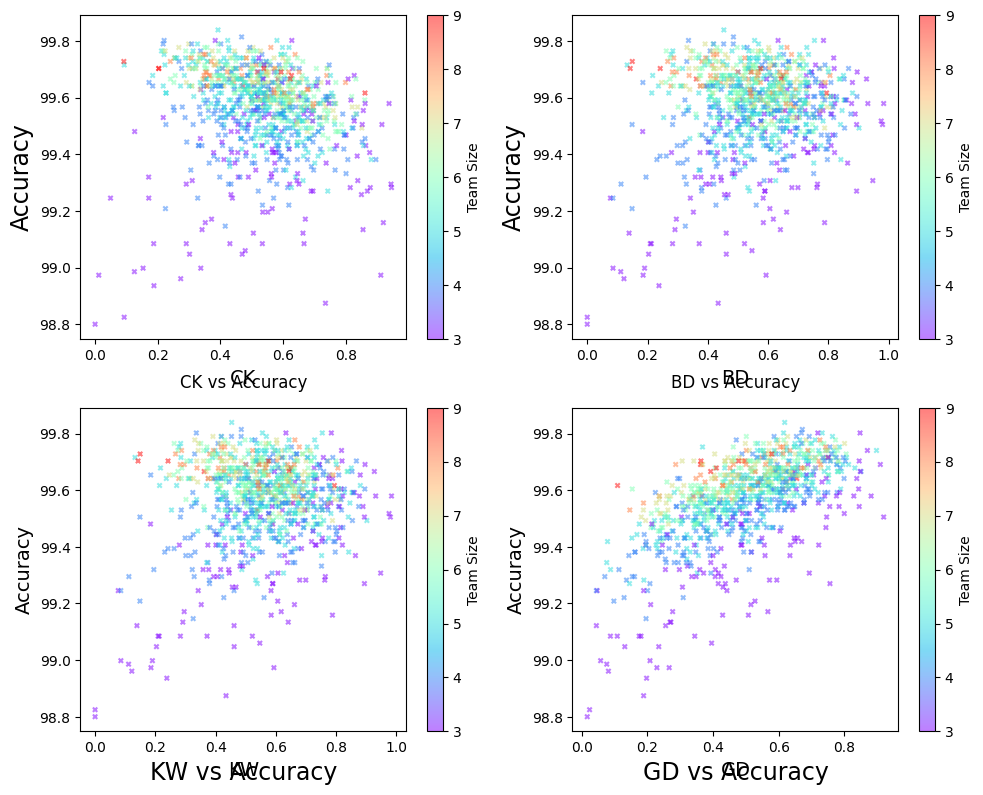

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatter plot CK vs ACC
sc1 = axes[0, 0].scatter(df['CK'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[0, 0].set_xlabel('CK', fontsize=14)
axes[0, 0].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc1, ax=axes[0, 0], label='Team Size')
axes[0, 0].annotate('CK vs Accuracy', (0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

# Scatter plot BD vs ACC
sc2 = axes[0, 1].scatter(df['BD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[0, 1].set_xlabel('BD', fontsize=14)
axes[0, 1].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc2, ax=axes[0, 1], label='Team Size')
axes[0, 1].annotate('BD vs Accuracy', (0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)

# Scatter plot KW vs ACC
sc3 = axes[1, 0].scatter(df['KW'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[1, 0].set_xlabel('KW', fontsize=14)
axes[1, 0].set_ylabel('Accuracy', fontsize=14)
fig.colorbar(sc3, ax=axes[1, 0], label='Team Size')
axes[1, 0].annotate('KW vs Accuracy', (0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=17)

# Scatter plot GD vs ACC
sc4 = axes[1, 1].scatter(df['GD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[1, 1].set_xlabel('GD', fontsize=14)
axes[1, 1].set_ylabel('Accuracy', fontsize=14)
fig.colorbar(sc4, ax=axes[1, 1], label='Team Size')
axes[1, 1].annotate('GD vs Accuracy', (0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=17)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


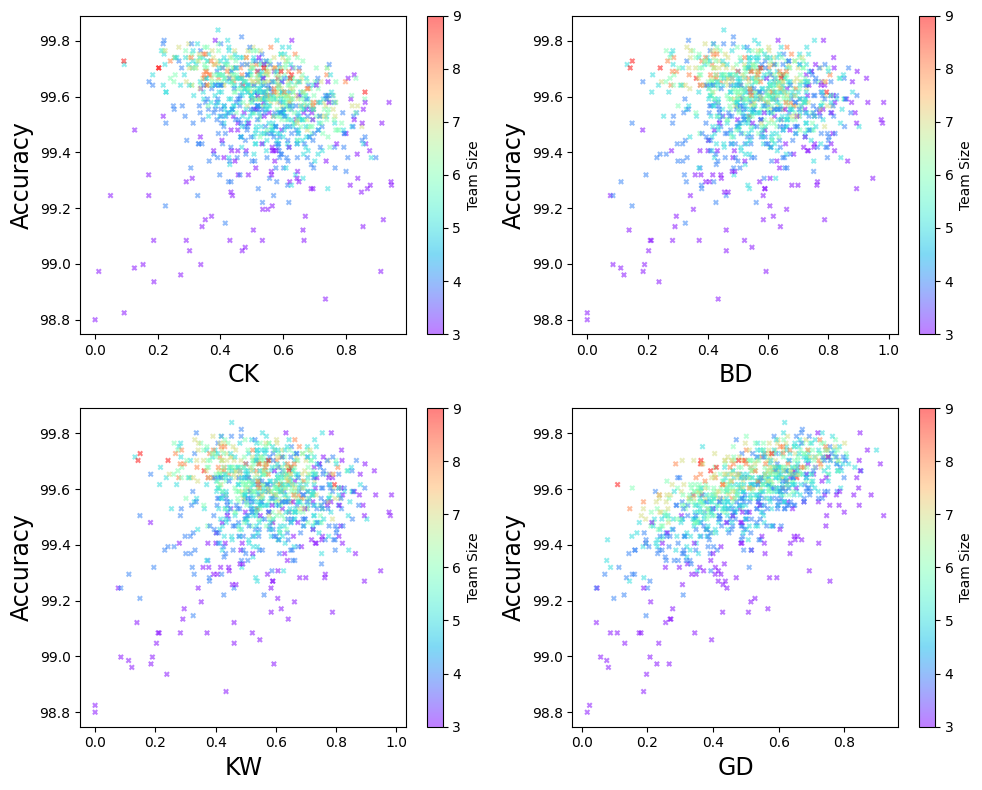

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Scatter plot CK vs ACC
sc1 = axes[0, 0].scatter(df['CK'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[0, 0].set_xlabel('CK', fontsize=17)
axes[0, 0].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc1, ax=axes[0, 0], label='Team Size')

# Scatter plot BD vs ACC
sc2 = axes[0, 1].scatter(df['BD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[0, 1].set_xlabel('BD', fontsize=17)
axes[0, 1].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc2, ax=axes[0, 1], label='Team Size')

# Scatter plot KW vs ACC
sc3 = axes[1, 0].scatter(df['KW'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[1, 0].set_xlabel('KW', fontsize=17)
axes[1, 0].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc3, ax=axes[1, 0], label='Team Size')

# Scatter plot GD vs ACC
sc4 = axes[1, 1].scatter(df['GD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
axes[1, 1].set_xlabel('GD', fontsize=17)
axes[1, 1].set_ylabel('Accuracy', fontsize=17)
fig.colorbar(sc4, ax=axes[1, 1], label='Team Size')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


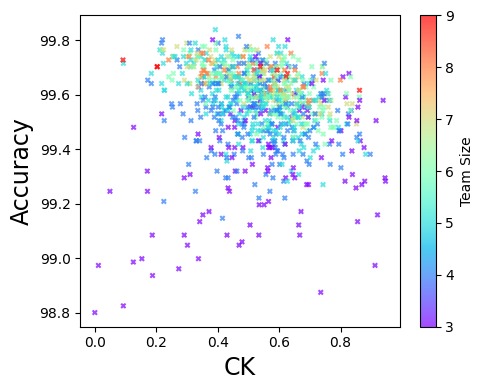

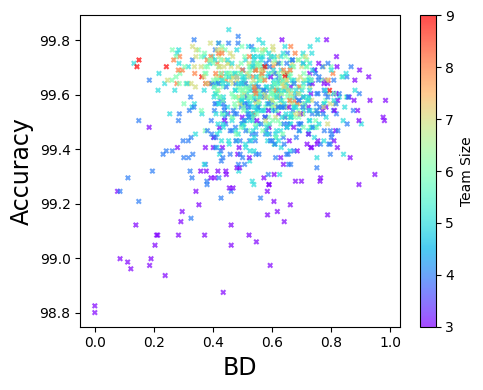

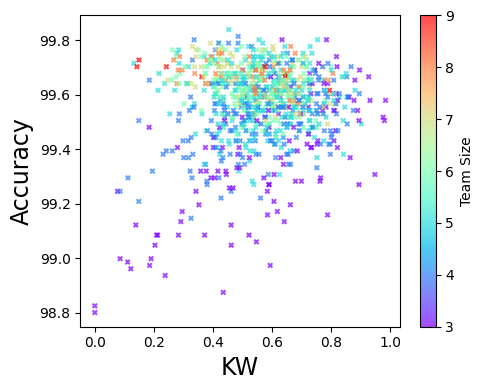

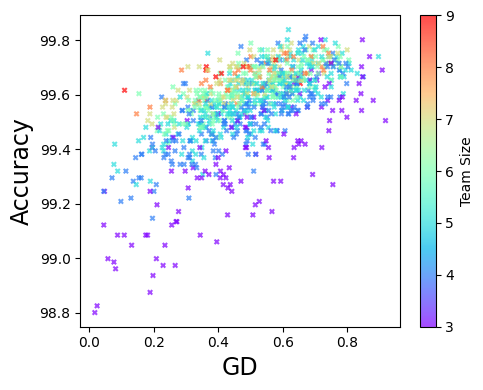

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Scatter plot CK vs ACC
plt.figure(figsize=(5, 4))
sc1 = plt.scatter(df['CK'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.7, marker='x')
plt.xlabel('CK', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.colorbar(sc1, label='Team Size')
plt.tight_layout()
plt.show()

# Scatter plot BD vs ACC
plt.figure(figsize=(5, 4))
sc2 = plt.scatter(df['BD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.7, marker='x')
plt.xlabel('BD', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.colorbar(sc2, label='Team Size')
plt.tight_layout()
plt.show()

# Scatter plot KW vs ACC
plt.figure(figsize=(5, 4))
sc3 = plt.scatter(df['KW'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.7, marker='x')
plt.xlabel('KW', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.colorbar(sc3, label='Team Size')
plt.tight_layout()
plt.show()

# Scatter plot GD vs ACC
plt.figure(figsize=(5, 4))
sc4 = plt.scatter(df['GD'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.7, marker='x')
plt.xlabel('GD', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.colorbar(sc4, label='Team Size')
plt.tight_layout()
plt.show()


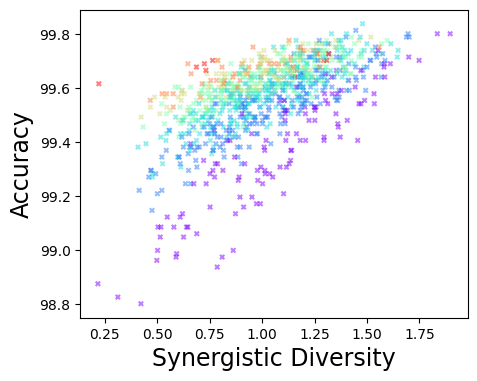

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.scatter(df['SQ'], df['acc'], c=df['Team Size'], cmap='rainbow', s=10, alpha=0.5, marker='x')
plt.xlabel('Synergistic Diversity', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.show()


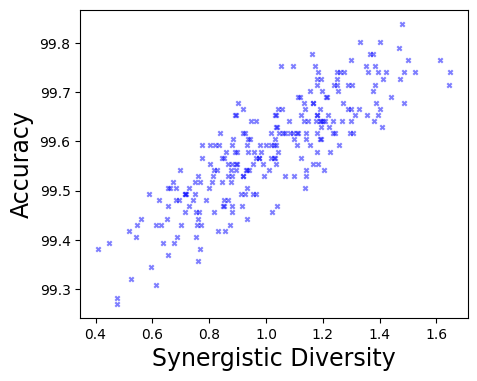

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for teams of size 5
df_filtered = df[df['Team Size'] == 5]

# Create the scatter plot for teams of size 5
plt.figure(figsize=(5, 4))
plt.scatter(df_filtered['SQ'], df_filtered['acc'], color='blue', s=10, alpha=0.5, marker='x')

# Label the axes
plt.xlabel('Synergistic Diversity', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Add grid and show the plot
plt.show()


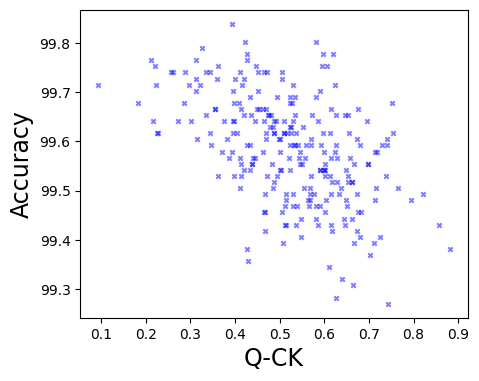

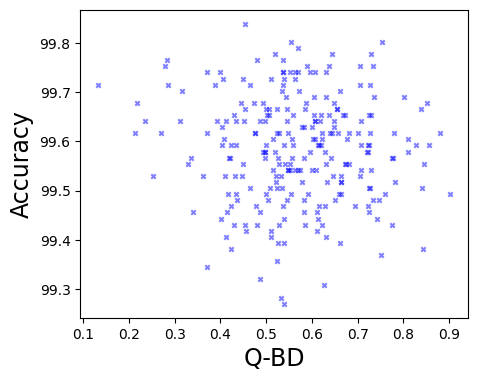

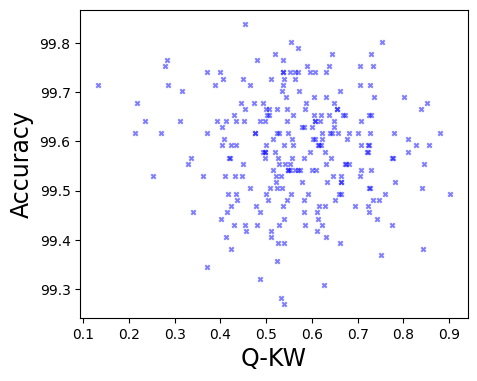

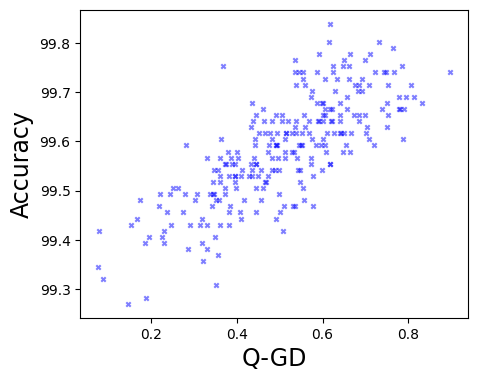

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for teams of size 5
df_filtered = df[df['Team Size'] == 5]

# Create the scatter plot for teams of size 5
plt.figure(figsize=(5, 4))
plt.scatter(df_filtered['CK'], df_filtered['acc'], color='blue', s=10, alpha=0.5, marker='x')

# Label the axes
plt.xlabel('Q-CK', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Add grid and show the plot
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for teams of size 5
df_filtered = df[df['Team Size'] == 5]

# Create the scatter plot for teams of size 5
plt.figure(figsize=(5, 4))
plt.scatter(df_filtered['BD'], df_filtered['acc'], color='blue', s=10, alpha=0.5, marker='x')

# Label the axes
plt.xlabel('Q-BD', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Add grid and show the plot
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for teams of size 5
df_filtered = df[df['Team Size'] == 5]

# Create the scatter plot for teams of size 5
plt.figure(figsize=(5, 4))
plt.scatter(df_filtered['KW'], df_filtered['acc'], color='blue', s=10, alpha=0.5, marker='x')

# Label the axes
plt.xlabel('Q-KW', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Add grid and show the plot
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame for teams of size 5
df_filtered = df[df['Team Size'] == 5]

# Create the scatter plot for teams of size 5
plt.figure(figsize=(5, 4))
plt.scatter(df_filtered['GD'], df_filtered['acc'], color='blue', s=10, alpha=0.5, marker='x')

# Label the axes
plt.xlabel('Q-GD', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)

# Add grid and show the plot
plt.show()


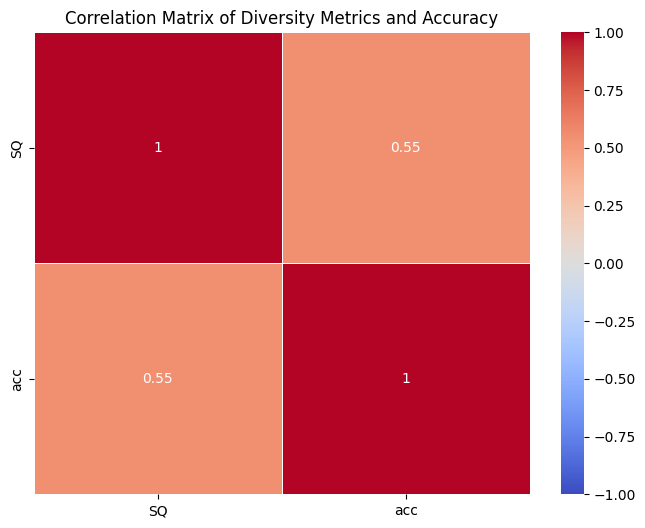

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame has the columns: 'CK', 'BD', 'KW', 'GD', 'acc'
# Compute the correlation matrix
corr_matrix = df[['SQ', 'acc']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Diversity Metrics and Accuracy')
plt.show()


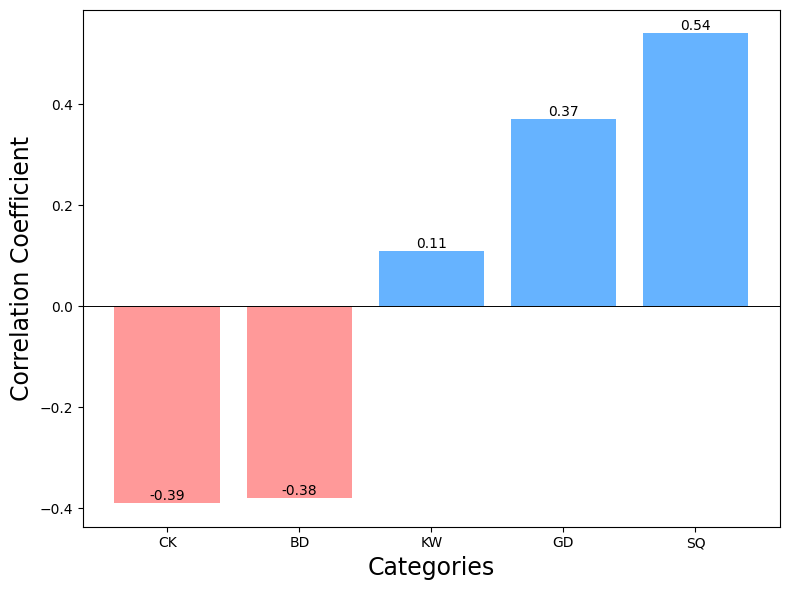

In [ ]:
import matplotlib.pyplot as plt

# Correlation values
categories = ['CK', 'BD', 'KW', 'GD', 'SQ']
correlation_values = [-0.39, -0.38, 0.11, 0.37, 0.54]

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, correlation_values, color=['#ff9999' if val < 0 else '#66b3ff' for val in correlation_values])

# Add horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add title and labels
plt.ylabel('Correlation Coefficient', fontsize=17)
plt.xlabel('Categories', fontsize=17)

# Display the plot
plt.tight_layout()
plt.show()
